# 08-Instrumental Variables (도구변수)
## Going Around Omitted Variable Bias


OVB(Omitted Variable Bias)를 다루는 한 가지 방법은 바로 생략된 변수를 우리의 모델에 추가하는 것입니다. 안타깝게도 생략된 변수에 대한 데이터가 항상 존재하는 것은 아니기 때문에 언제나 가능한 것은 아니죠. 예를 들어, 교육이 임금에 미치는 영향에 대한 모델을 살펴볼까요?


$log(hwage)_i = \beta_0 + \kappa \ educ_i + \pmb{\beta}Ability_i + u_i$

교육($\kappa$)이 임금($log(hwage)$)에 미치는 인과적 영향을 파악하기 위해선 역량($Ability_i$) 요인을 통제할 필요가 있습니다. 이 요인을 통제하지 않는다면 우리는 아마 작아보일수도 있지만 절대 작지 않은 편향(bias)을 가지게 될 것이고, 결국 역량 변수로 인한 편향은 교란 요인(confounder)이 되어 우리가 가하는 처치라 할 수 있는 교육 변수와 그리고 결과 변수인 수입에도 모두 영향을 주게 될 것입니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.iv import IV2SLS

%matplotlib inline

pd.set_option("display.max_columns", 5)
style.use("fivethirtyeight")

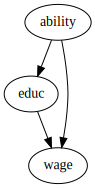

In [7]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

위와 같은 상황을 피할 수 있는 한 가지 방법은 교육이 임금에 주는 영향을 측정할 때 일정한 수준의 역량 변수를 통제하는 것입니다. 선형 회귀 모델에 역량 변수를 포함함으로써 통제할 수도 있겠죠? 하지만 문제는 우리에게 '역량'을 측정할만한 좋은 척도가 없다는 것입니다. 우리가 고려할 수 있는 그나마 좋은 척도는 IQ가 될 수 있겠네요.

그러나 아직 절망할 때는 아닙니다. 여기서 우리는 바로 도구변수(Instrumental Variables)를 활용할 수 있습니다! 도구변수의 아이디어는 처치(T) 변수를 유발하는 다른 변수를 찾는 것에서부터 시작되며, 도구변수는 처치를 통한 결과(Y)와만 상관 관계가 있어야 합니다. 다르게 말하자면, 도구변수($Z_i$)는 $Y_0$와는 상관 관계가 성립하지 않으면서 $T$와의 상관 관계는 성립해야 합니다. 이것을 Exclusion Restriction(제외 제한)이라고 하곤 하죠.

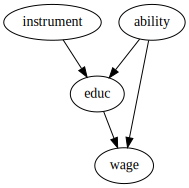

In [8]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("instrument", "educ")
g

만약 우리가 이러한 도구변수(IV)가 있다면, 아래의 도구변수(IV) 식에 따라 인과 효과($\kappa$)를 밝혀낼 수 있겠죠? 일단은 가장 이상적인 식에 대해 생각해봅시다. 이제부터 처치를 $T$라 하고, 교란 변수를 $W$라 하겠습니다.


$Y_i = \beta_0 + \kappa \ T_i + \pmb{\beta}W_i + u_i$


그러나 우리는 $W$에 대한 데이터가 없으므로 우리가 할 수 있는 것은...


$Y_i = \beta_0 + \kappa\ T_i + v_i$
$v_i = \pmb{\beta}W_i + u_i$


$W$가 교란변수기 때문에, $Cov(T, v) \neq 0$가 성립되겠죠? 우리는 그다지 길지 않은 식을 가지고 있어요. 그리고 우리의 예시에서 이건 바로 능력과 교육이 연관성이 있다는 것을 의미합니다. 이런 경우에 우리가 만약 짧은 회귀 분석을 진행한다면, 생략된 변수들로 인해 편향된 추정치($\kappa$)가 산출될 것입니다.


자! 이제 도구변수(IV)의 마법을 볼 시간이에요. 도구변수 $Z$가 처치 $T$를 통해서만 결과 변수와 상관성이 있기 때문에, $Cov(Z,v) = 0$ 식이 성립될 것입니다. 만약 그렇지 않다면 $W$를 거쳐 $Z$에서 $Y$로 가는 또다른 경로가 있겠죠? 이를 잘 명심하세요! 우리는 바로 아래와 같은 수식을 얻을 수 있으니까요!


$Cov(Z,Y) = Cov(Z,\beta_0 + \kappa\ T_i + v_i) = \kappa Cov(Z,T) + Cov(Z, v) = \kappa Cov(Z,T)$


양 쪽을 $V(Z_i)$로 나누고 식을 정리해보면,


$\kappa = \dfrac{Cov(Y_i, Z_i)/V(Z_i)}{Cov(T_i, Z_i)/V(Z_i)} = \dfrac{\text{Reduced Form}}{\text{1st Stage}}$


분자와 분모는 모두 회귀계수(Regression Coefficients; 공분산을 분산으로 나눈 값)입니다. 분자는 $Z$에 대한 $Y$의 회귀 분석 결과죠. 다시 말해, $Y$에 대한 $Z$의 "영향"이라고 할 수 있습니다. 우리는 $Z$가 $T$를 통해서만 $Y$에 영향을 줄 수 있다는 것을 알고 있기 때문에, $Z$가 $Y$의 원인이 아니라는 것을 파악할 수 있죠. 오히려 $Z$가 $T$를 통해 $Y$에 미치는 효과가 얼마나 큰 지를 포착할 수 있게끔 해주죠. 이 분자는 너무 유명해서 The reduced form coefficient 라는 이름 또한 가지고 있죠.

분모 또한 회귀계수(Regression Coefficient)입니다. 이번에는 $Z$에 대한 $T$의 회귀식이죠. 이 회귀식은 $T$에 대한 $Z$의 영향을 알 수 있게끔 해주죠. 이 분모도 너무 유명해서 1st Stage Coefficient라는 이름을 가지고 있습니다.

이 식을 더 멋지게 봐보도록 할까요? 바로 부분 도함수(Partial derivatives)의 측면에서요! $T$에 대한 $Z$를 조정함으로써 우리는 $Y$에 대한 $T$의 영향과 $Y$에 대한 $Z$의 영향이 같다는 것을 알 수 있어요.


$\kappa = \dfrac{\frac{\partial y}{\partial z}}{\frac{\partial T}{\partial z}} = \dfrac{\partial y}{\partial z} * \dfrac{\partial z}{\partial T} =  \dfrac{\partial y}{\partial T}$


이것이 우리에게 시사하는 바는 대다수의 사람들이 평가하는 것보다 조금 더 미묘합니다. 더 멋지죠! 우리가 도구변수(IV)를 이렇게 활용함으로써 우리는 이렇게 말할 수 있습니다.
"교란 변수때문에 Y에 대한 T의 영향도를 측정하기는 어려워.. 근데 말이야 나는 Y에 대한 Z의 영향도는 쉽게 찾을 수 있어! 어떻게 하나고? Z와 Y를 유발하는 것은 아무 것도 없기 때문이지!(Exclusion Restriction) 그런데 사실 나는 Y에 대한 T의 영향도가 궁금한거지 Y에 대한 Z의 영향도가 궁금한게 아니란 말이지... 그래서 나는 방법을 하나 찾았어. Z 대신 T에 대한 효과로 변환하기 위해 T에 대한 Z의 효과를 조정(Scale)함으로써 Y에 대한 Z의 효과를 측정할 거야!"

또한 도구변수가 더미가 된 심플한 상황에서도 이를 확인할 수 있습니다. 이러한 경우에는 도구변수는 평균의 두 차이 사이의 비율에 의해 더욱 단순화됩니다.


$\kappa = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}$


이 비율은 **Wald Estimator**라고도 명명됩니다. 다시 말해서, 우리는 도구변수를 말할 때, Y에 대한 처치 T의 효과(실제론 굉장히 밝혀내기 어렵죠.)를 말하고 싶어하는 건데요. 따라서 우리는 우선 Y에 대한 Z의 효과를 먼저 주목하는 것입니다. 도구변수의 정의에 따르자면, Z의 경우 반드시 T를 통해서만 Y에 영향을 미칠 수 있으므로, 우리는 드디어 Y에 대한 Z의 효과를 Y에 대한 T의 효과로 바꿔볼 수 있는 것이죠. 이렇게 하기 위해 T에 대한 Z의 효과를 확인함으로써 Y에 대한 Z의 효과를 측정할 수 있는 것이죠.

## Quarter of Birth and the Effect of Education on Wage

지금까지, 우리는 이 도구변수들을 처치를 통해서만 결과에 영향을 미치는 기적적인 타당성을 가진 마법의 변수로 취급해 왔습니다. 솔직히 말해보자면, 좋은 도구변수는 구하기가 매우 어렵습니다. 좋은 도구변수를 구했을 때 우리가 기적이 일어났다고 생각하는 것도 과언은 아니죠. 소문에 의하면 시카고 경제 대학의 멋진 학생들은 주변 바에서 어떻게 엄청난 도구변수를 만들 수 있을지에 대해 이야기한다고 합니다.

![good-iv](./data/img/iv/good-iv.png)

하지만 여전히, 우리는 우리의 가설을 좀 더 구체적으로 만들기 위한 몇 가지 흥미로운 도구변수를 가지고 있습니다. 우리는 교육이 임금에 미치는 영향을 다시 한번 추정해볼건데요. 이를 위해, 우리는 그 사람의 출생 4분기를 도구변수 $Z$로 사용할 것입니다.

이 아이디어는 미국의 의무 출석법을 활용한 것인데요. 이 법은 아이들이 학교에 입학하는 해의 1월 1일까지 6살이 되어야 한다고 명명되어 있습니다. 이러한 이유로, 연초에 태어난 아이들은 더 많은 나이에 학교에 입학하게 되는데요. 의무 출석법은 또한 학생들이 16살이 될 때까지 학교에 있어야 하며, 그 시점에서 그들은 법적으로 중퇴가 허용된다는 내용도 있습니다. 결과적으로 그 해에 늦게 태어난 사람들은 평균적으로 연초에 태어난 사람들보다 더 많은 교육을 받게 되는 것이죠.

![qob](./data/img/iv/qob.png)

출생 분기가 능력 요소와는 무관하여 교육이 임금에 미치는 영향을 교란시키지 않는 다는 것을 받아들인다면, 우리는 출생 분기를 도구변수로 사용할 수 있습니다. 다시 말해, 우리는 출생 분기가 교육에 미치는 영향 외에는 임금에 영향을 미치지 않는다고 생각해야 합니다. 이거 꽤 설득력 있지 않나요?

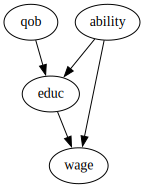

In [4]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("qob", "educ")
g

이 분석을 위해 우리는 10년마다 실시되는 인구조사의 데이터를 사용할 수 있는데요. 이는 도구변수(IV)에 대한 눈문에서  [Angrist and Krueger](https://economics.mit.edu/faculty/angrist/data1/data/angkru1991)가 사용한 것과 같은 데이터입니다. 이 데이터 셋에는 임금에 대한 로그값, 결과 변수, 처치 변수인 교육 기간에 대한 정보가 있습니다. 또한 출생 분기, 장비 및 출생 연도 및 출생 상태와 같은 추가 컨트롤 변수에 대한 데이터도 있습니다.

In [5]:
data = pd.read_csv("./asciiqob.csv")
data.head()

log_wage  years_of_schooling  year_of_birth  quarter_of_birth  \
0  5.790019                  12             30                 1   
1  5.952494                  11             30                 1   
2  5.315949                  12             30                 1   
3  5.595926                  12             30                 1   
4  6.068915                  12             30                 1   

   state_of_birth  
0              45  
1              45  
2              45  
3              45  
4              37

### The 1st Stage

출생 분기를 도구변수로 활용하기 전에 우리는 유효성에 대해 먼저 검증할 필요가 있습니다. 아래와 같은 두 가지 도구변수 가정을 충족해야 하는데요.

1. $Cov(Z, T) \neq 0$ 도구변수가 실제로 처치변수에 영향을 미친다는 첫번째 단계를 충족해야합니다.
2. $Y \perp Z | T$ Exclusion Restriction(제외 제한): 도구변수 Z가 처치 T를 통해서만 결과 Y에 영향을 준다는 가정 또한 충족해야 합니다.

첫번째 가정은 천만 다행으로 검증이 가능합니다. 우리는 데이터를 통해 $Cov(Z, T)$dl 0이 아님을 확인할 수 있습니다. 우리의 예시에서, 만약 출생 분기가 정말로 도구변수로 기능하려면, 우리는 올해 4분기에 태어난 사람들이 1분기에 태어난 사람들보다 약간 더 많은 교육 시간을 받았다는 것을 확인해야 합니다. 이를 위해 통계 검정 전에 데이터를 시각화해서 직접 확인해볼까요?

In [6]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])
              [["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

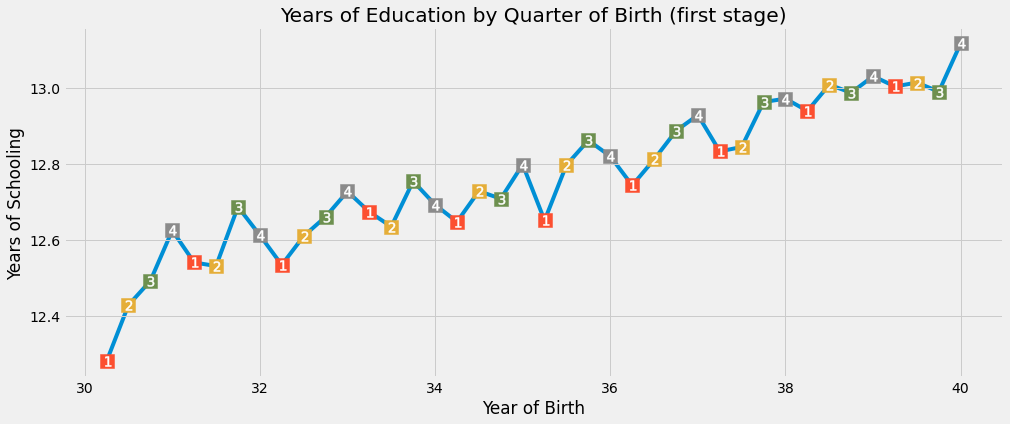

In [7]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling");

놀랍게도, 분기마다 이어지는 학교 교육에는 계절성(Seasonality)이 있네요. 시각적으로, 우리는 1분기에 태어난 사람들이 4분기에 태어난 사람들보다 거의 항상 더 적은 교육을 받는다는 것을 알 수 있습니다. (우리가 일단 출생 연도를 통제하면 일반적으로 마지막 분기에 태어난 사람들은 더 많은 교육을 받습니다.)

좀 더 엄격하게 말하자면, 우리는 이런 1단계를 선형 회귀로 실행할 수 있습니다. 먼저 출생 분기를 더미 변수로 변환해볼까요?

In [8]:
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
                             for q in data["quarter_of_birth"].unique()})

factor_data.head()

log_wage  years_of_schooling  ...  q3  q4
0  5.790019                  12  ...   0   0
1  5.952494                  11  ...   0   0
2  5.315949                  12  ...   0   0
3  5.595926                  12  ...   0   0
4  6.068915                  12  ...   0   0

[5 rows x 9 columns]

문제를 단순하게 하기 위해, 현재 도구변수로는 4분기만 활용해 봅시다. 이제 수년간의 학교 교육, 처치, 출생 분기에 해당하는 도구변수의 회귀를 실행해볼까요? 이는 우리가 위에서 본 것처럼 실제로 출생 분기가 교육 시간에 긍정적으로 영향을 미치는지를 보여줄 것입니다. 우리는 여기서 출생 연도 또한 통제할 필요가 있기 때문에 추가 통제적 조치로 출생 상태를 추가할 것입니다.

In [9]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272785462
q4 p-value:,  5.464829416657941e-15


한 해의 4분기에 태어난 사람들은 다른 분기에 태어난 사람들보다 평균적으로 0.1년 더 많은 교육을 받은 것으로 보이네요. p-value가 0에 가깝습니다. 이것으로 출생 분기가 학교 교육 시간에 실제로 영향을 주는지에 대한 사례를 마무리 지어볼까요?

![incomplete-files](./data/img/iv/incomplete-files.png)

## The Reduced Form

안타깝게도 두 번째 도구변수 가정은 확인할 수 없습니다. 우리는 찬성하는 주장만 할 수 있지요. 우리는 출생 분기가 잠재적인 수입에 영향을 미치지 않는다고 표현할 수는 있죠. 다시 말해서, 사람들이 태어나는 시간은 교육에 미치는 영향 외에, 그들의 개인적인 능력이나 수입에 차이를 일으킬 수 있는 요소가 아니라는 것이죠. 출생 분기가 수입에 미치는 영향이 무작위로 할당된 것과 같다는 것입니다. (엄밀히 말하면 완전 랜덤은 아닙니다. 여름이 끝날 무렵이나 어떤 종류의 휴일 즈음에 임신하는 경향이 있다는 자료가 있긴 합니다. 하지만 저는 이 경향이 교육을 통해서가 아닌, 다른 방법으로도 소득에 영향을 미친다는 긍적적인 이유를 생각하기 어렵네요.)

두번째 가정인 Exclusion Restriction에 찬성하는 주장을 펼쳤으므로 좀 더 간소하게 진행해볼까요? 요약된 방식은 도구변수가 결과에 어떤 영향을 미치는지 파악하는 것을 목표로 합니다. 이 모든 것들은 처치에 미치는 영향 때문이라고 가정하기 때문에, 처치(T)가 결과(Y)에 어떻게 영향을 미치는지 알 수 있습니다. 다시 한 번, 회귀 분석을 진행하기 전에 시각적으로 이것을 평가해볼까요?

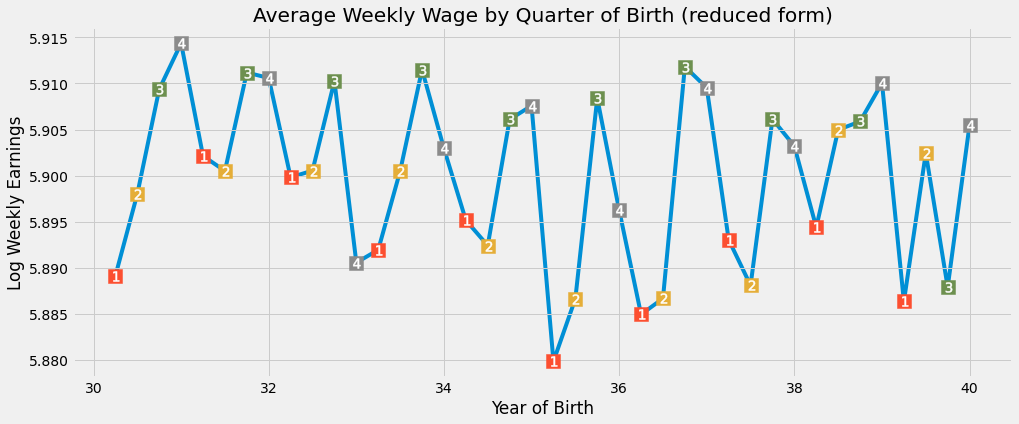

In [10]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Average Weekly Wage by Quarter of Birth (reduced form)")
plt.xlabel("Year of Birth")
plt.ylabel("Log Weekly Earnings");

다시 한 번, 우리는 출생 분기에 따른 임금에 대한 계절성을 볼 수 있습니다. 연초에 태어난 사람들보다 그 해 늦게 태어난 사람들의 소득이 약간 더 높습니다. 이 가설을 테스트하기 위해 임금 로그 값에 대한 도구변수인 q4를 다시 회귀 분석을 진행할 것입니다. 또한 1단계와 동일한 추가 통제를 진행해봅시다.

In [11]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])

q4 parameter estimate:,  0.008603484258925376
q4 p-value:,  0.0014949127203772554


또 다시 한번, 우리는 중요한 결과를 얻었네요. 올해 4분기에 태어난 사람들은 평균적으로 임금이 무려 0.8% 더 높네요. 이번에는 p-value값이 이전처럼 0에 수렴하진 않지만, 0.0015로 통계적으로 아주 유의한 수치입니다.

## Instrumental Variables by Hand

우리가 첫번째 단계와 요약된 방식을 모두 확인했으므로, 우리는 요약된 방식으로 첫번째 단계의 효과를 확장할 수 있습니다. 첫번째 단계의 결정계수(coefficient)가 0.1과 같았기 때문에 요약된 방식의 결정계수의 효과를 거의 10배까지 증가시킬 것입니다. 이로 인해 우리는 평균적인 인과 효과에 대한 편향되지 않은 도구변수(IV)를 알 수 있겠죠?

$ATE_{IV} = \dfrac{\text{Reduced Form}}{\text{1st Stage}}$

In [12]:
reduced_form.params["q4"] / first_stage.params["q4"]

0.08530286490881953

위 값의 의미는 우리가 매 학년마다 임금이 8% 인상될 것으로 예상한다는 것인데요.

도구변수(IV) 추정치를 얻는 또 다른 방법은 2단계 최소 제곱 회귀분석(2SLS)을 진행하는 것입니다. 2SLS를 통해 이전과 같이 첫 번째 단계를 수행한 후, 첫 번째 단계의 적합치를 활용해 처치 변수($T$)를 대신하는 두 번째 단계를 실행해 볼 수 있습니다.

$educ_i = \gamma_0 + \gamma_1 * q4_i + \gamma_2 yob_i + \gamma_3 sob_i + v_i$
$log(wage)_i = \beta_0 + \beta_1 educ_i + \beta_2 yob_i + \beta_3 sob_i + u_i$
$log(wage)_i = \beta_0 + \beta_1 [\gamma_0 + \gamma_1 * q4_i + \gamma_2 yob_i + \gamma_3 sob_i + v_i ]  + \beta_2 yob_i + \beta_3 sob_i + u_i$

한 가지 유념할 점은 우리가 **두 번째 단계에서 추가할 모든 통제 변수는 도구변수(IV)의 첫 번째 단계에도 추가되어야 한다는 것**입니다.

In [13]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]

0.08530286490889338

확인한대로, 모든 파라미터는 완전히 똑같네요. 도구변수를 확인하는 두번째 방법의 직관성이 주는 인사이트로 인해 이 방법은 상당히 유용합니다. 2SLS에서 처치변수의 새로운 버전을 만드는데요. 이는 생략된 변수 편향(Omitted Variable bias)에서 제거되는 것입니다. 그런 다음 이 제거된 버전의 처리, 즉 1단계의 적합치를 선형 회귀(Linear Regression)에서 사용하는 것이죠.

그러나 우리는 도구변수를 직접 실행하진 않습니다. 이러한 방법이 번거로워서가 아니라 두번째 단계로부터 얻는 표준 오차(standard error)를 확인하기 어렵기 때문인데요. 대신에 우리는 모델을 돌릴 수 있죠. 파이썬에선 2SLS를 [선형 회귀 모델](https://bashtage.github.io/linearmodels/)을 통해 돌려볼 수 있습니다.

2SLS의 공식은 살짝 다른데요. 공식 내부의 [ ] 사이에 첫 번째 단계를 추가해야 합니다. 우리의 경우에는 우리는 `years_of_schooling ~ q4`를 추가해야 합니다. 두 번째 단계에 통제 변수을 포함하면 모델이 자동으로 이 작업을 수행하므로 첫 번째 단계에 추가 통제 변수를 추가할 필요는 없습니다. 이러한 이유들로 인해, 우리는 첫 번째 단계에서 공식 밖에 `year_of_birth`와 `state_of_birth`를 추가하게 됩니다.

In [14]:
def parse(model, exog="years_of_schooling"):
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se) + param}")
    print(f"P-value: {p_val}")
    
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.08530286491077277
SE: 0.025540812814796848
95 CI: [0.03524287 0.13536286]
P-value: 0.0008381914676560687


다시 한번, 우리는 파라미터가 이전과 정확히 같다는 것을 알 수 있는데요. 추가적인 이점은 현재 우리가 확인할 수 있는 유효한 표준 오류가 있다는 것입니다. 이를 감안하면 1년간의 추가 교육으로 평균 8.5%의 임금 인상이 기대된다고 볼 수 있겠네요.

## Multiple Instruments

모델을 돌리는 것의 또 다른 장점은 우리가 여러 개의 도구변수(IV)를 추가할 수 있다는 건데요. 우리 예시를 살펴볼까요? 우리는 모든 태어난 분기를 수년 간의 학교 교육의 도구변수로 활용할 수 있을거에요.

In [15]:
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]'
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv_many_zs)

Parameter: 0.10769370487719243
SE: 0.019557149009348015
95 CI: [0.06936169 0.14602572]
P-value: 3.657974678716869e-08


3개의 더미들을 모두 포함하여, 현재 예상 교육 수익률은 0.1이겠네요. 이는 추가 교육을 받을 때마다 평균 10%의 수익 증가를 예상할 수 있다는 것을 의미할 수 있겠습니다. 기존 OLS 추정치와 비교해볼까요?. 그러기 위해서는 다시 2SLS를 사용할 수 있지만, 1단계를 제외하고 해봐야겠네요.

In [16]:
formula = "log_wage ~ years_of_schooling + C(state_of_birth) + C(year_of_birth) + C(quarter_of_birth)"
ols = IV2SLS.from_formula(formula, data=data).fit()
parse(ols)

Parameter: 0.0673257281766455
SE: 0.00038839984390110925
95 CI: [0.06656446 0.06808699]
P-value: 0.0


교육에 따른 수익은 OLS가 2SLS에 비해 낮은 것으로 보이네요. 이것은 OVB(생략된 변수 편향; Omitted Variables bias)가 처음처럼 그렇게 강하게 영향을 미치지 않았을 수도 있음을 추측해 볼 수 있겠네요. 또 신뢰 구간을 유의해서 살펴봐야겠네요. 2SLS의 CI는 OLS 추정치보다 훨씬 넓네요. 이에 대해 더 자세히 알아봐볼까요?

## Weakness of Instruments

![weak-iv](./data/img/iv/weak-iv.png)

도구변수(IV)를 다룰 때 반드시 유념해야 하는 점은, 우리가 간접적으로 ATE(Average Treatment Effect)를 추정하고 있다는 것인데요. 우리의 측정치는 첫 번째 단계와 두 번째 단계 모두에게 의존하고 있습니다. 처치(T)가 결과에 미치는 영향이 정말 강하다면, 두 번째 단계 또한 쎄질 것입니다. 그러나 첫 번째 단계가 그렇게 강하지 않다면 두 번째 단계가 얼마나 강한지는 별로 신경 쓸 필요가 없습니다. 첫 번째 단계가 약하다는 것은 도구변수(IV)가 처치와 아주 적은 상관 관계를 가지고 있다는 것을 의미하기 때문인데요. 그러므로.. 우리는 도구변수로부터 처치에 대해 많이 알 수가 없는 것이죠.

도구변수(IV)의 표준 오차(Standard Error)에 대한 공식은 살짝 복잡하고 직관적이지 않기 때문에 이 문제를 해결하기 위해 다른 방법을 시도해볼껀데요. 결과 Y, 관찰되지 않은 교란 변수 U 및 추가 통제 변수 X에 2.0의 효과를 갖는 처치 T가 있는 데이터를 돌려볼 것입니다. 또한 첫 번째 단계에서 서로 다른 영향력을 가진 여러 도구변수를 실행해 볼 것입니다.

$X \sim N(0, 2^2)
U \sim N(0, 2^2)
T \sim N(1+0.5U, 5^2)
Y \sim N(2+ X - 0.5U + 2T, 5^2)
Z \sim N(T, \sigma^2) \text{ for }\sigma^2 \text{ in 0.1 to 100}$

In [17]:
np.random.seed(12)
n = 10000
X = np.random.normal(0, 2, n) # observable variable
U = np.random.normal(0, 2, n) # unobservable (omitted) variable
T = np.random.normal(1 + 0.5*U, 5, n) # treatment
Y = np.random.normal(2 + X - 0.5*U + 2*T, 5, n) # outcome

stddevs = np.linspace(0.1, 100, 50)
Zs = {f"Z_{z}": np.random.normal(T, s, n) for z, s in enumerate(stddevs)} # instruments with decreasing Cov(Z, T)

sim_data = pd.DataFrame(dict(U=U, T=T, Y=Y)).assign(**Zs)

sim_data.head()

U         T  ...        Z_48        Z_49
0  2.696148  8.056988  ... -117.798705  -13.485292
1  2.570240  0.245067  ... -209.727577  -70.792948
2  0.664741  5.597510  ...   60.562232   47.619414
3  1.037725  0.493532  ...   78.136513 -108.322304
4 -2.590591 -6.263014  ...   78.776566  -80.547214

[5 rows x 53 columns]

더블 체크를 위해서 Z와 T의 상관관계(correlation)가 실제로 감소하는지를 확인해볼까요?

In [18]:
corr = (sim_data.corr()["T"]
        [lambda d: d.index.str.startswith("Z")])

corr.head()

Z_0    0.999807
Z_1    0.919713
Z_2    0.773434
Z_3    0.634614
Z_4    0.523719
Name: T, dtype: float64

드디어 우리는 도구변수마다 각각의 도구변수 모델을 실행해보고, ATE 추정치와 표준 오차를 모두 알 수 있을 거에요.

In [19]:
se = []
ate = []
for z in range(len(Zs)):
    formula = f'Y ~ 1 + X + [T ~ Z_{z}]'
    iv = IV2SLS.from_formula(formula, sim_data).fit()
    se.append(iv.std_errors["T"])
    ate.append(iv.params["T"])

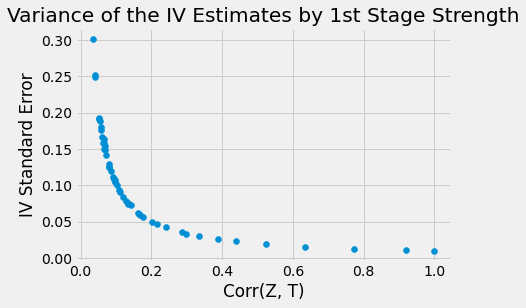

In [20]:
plot_data = pd.DataFrame(dict(se=se, ate=ate, corr=corr)).sort_values(by="corr")

plt.scatter(plot_data["corr"], plot_data["se"])
plt.xlabel("Corr(Z, T)")
plt.ylabel("IV Standard Error");
plt.title("Variance of the IV Estimates by 1st Stage Strength");

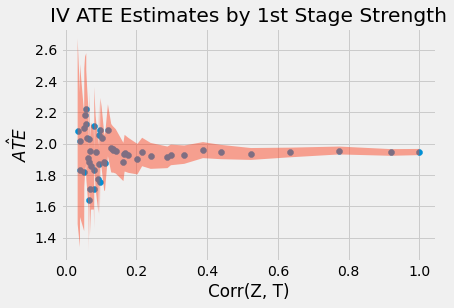

In [21]:
plt.scatter(plot_data["corr"], plot_data["ate"])
plt.fill_between(plot_data["corr"],
                 plot_data["ate"]+1.96*plot_data["se"],
                 plot_data["ate"]-1.96*plot_data["se"], alpha=.5)
plt.xlabel("Corr(Z, T)")
plt.ylabel("$\hat{ATE}$");
plt.title("IV ATE Estimates by 1st Stage Strength");

위 플롯에서 확인할 수 있는대로, T와 Z의 상관관계가 매우 약할 때 측정치가 매우 크게 흩뿌러져 있는 것을 알 수 있는데요. 왜냐하면 상관관계가 낮을 때 SE 값 또한 증가하기 때문입니다.

또 한 가지 알아야할 점은 2SLS가 편향성이 있다는 것입니다. 높은 상관관계에도 불구하고 파라미터 측정치가 2.0의 ATE에 여전히 도달하지 못하기 때문입니다. 실제로 2.0이라는 값은 심지어 95% 신뢰구간(CI) 안에 있지도 않습니다. 따라서 2SLS가 일관적이기만 한다는 것인데요. 이는 모수의 크기가 충분히 커진다면 실제 파라미터 값에 가까워질 수 있다는 것을 의미하기도 합니다. 그러나 어느 정도 크기가 충분한지 우리는 알 수가 없습니다. 이러한 편향이 어떻게 작용하는지 이해하기 위해 몇 가지 방법들을 고려해볼 수만 있겠지요.

1. 2SLS는 OLS에 치우쳐있다는 것입니다. 이는 OLS가 긍부정적인 편향을 가지고 있다면 2SLS 또한 그 편향을 가지고 있다는 것인데요. 2SLS의 장점은 생략된 변수에 의해 일관성을 가지지 못하는 OLS에 비해 그나마 일관성을 띄고 있다는 것이죠. 위 예시로 인해 우리의 교란 변수 U는 결과엔 부정적인 영향을 미치지만 처치 변수와는 긍정적인 상관관계를 가지고 있죠. 결국 이는 부정적인 편향으로 이어지지만요. 이러한 이유들로 인해 실제 값(부정 편향) 하에 ATE 추정치를 확인하는 것이겠죠.
2. 편향은 우리가 추가하는 도구변수만큼 증가한다는 것인데요. 우리가 너무 많은 도구변수를 집어넣는다면 2SLS 점점 OLS에 가까워진다는 것입니다.

우리가 편향이 어떻게 동작하는지 안다 하더라도, 우리는 적어도 도구변수를 활용할 떄 흔히 발생하는 실수들은 피할 수 있어야겠죠?

1. 도구변수를 직접 돌려보는 것을 피하세요. 직접 하는 것은 실제로 파라미터 측정치가 맞다고 하더라도 잘못된 표준 오차를 발생시킬 수 있어요. 표준 오차는 사라지지 않을 꺼에요. 우리가 모델을 사용하여 옳은 표준 오차를 확인할 수 있는데 굳이 직접할 필요는 없겠죠?
2. 첫 번째 단계에서 OLS 이외의 방법을 사용하는 것을 피하세요. 수많은 데이터 사이언티스트들은 도구변수를 접하고 더 좋은 방법론을 활용할 수 있다고 생각하는데요. 예를 들어 더미처리하는 것을 보고 로지스틱 회귀분석을 활용하는 방법을 생각하는데요. 결국엔 그들이 더미 변수를 예측하고 있는 것이겠죠? 문제는 바로 이것이 완전히 잘못되었다는 것인데요. 도구변수의 일관성은 잔차의 직교성 특징을 가지고 있는 OLS만이 제공해줄 수 있는 것이므로 첫 번째 단계에서 OLS 이외의 방법론을 도입한다면 편향된 결과가 도출되겠죠. (OBS: 도구변수(IV)를 위해 머신 러닝을 사용하는 최신 기술이 있지만, 그 결과가 상당히 의문이 들긴 하네요.)

## Key Ideas

우리는 지금까지 도구변수를 활용할 수 있을때 어떻게 OVB(생략된 편항)를 해결할 수 있는지 살펴보았습니다. 도구변수는 처치변수와 상관관계가 있으면서(첫 번째 단계) 처치변수를 통해서만 결과 변수에 영향을 주는 것(Exclusion Restriction)을 의미합니다. 우리는 태어난 분기라는 도구변수 예시를 통해 교육이 임금에 미치는 영향을 살펴보았습니다.

그런 다음 도구변수, 즉 2SLS를 사용하여 인과 효과를 추정하는 방법을 배웠습니다. 또한 도구변수가 만능이 아니라는 것을 알았지요. 첫 번째 단계가 약할 때 추정하기 매우 번거로울 수 있다는 것이죠. 또한, 일관성이 있긴 하지만, 2SLS는 여전히 인과 효과를 추정하기 위한 편향된 방법이라는 것입니다.

## References

저는 이 책 전체를 Joshua Angrist, Alberto Abadie, Christopher Walters의 놀라운 계량경제학 수업에 대한 찬사로 생각하고 싶습니다. 여기 있는 대부분의 아이디어들은 미국 경제 협회의 수업에서 따온 것들입니다. 그들을 보는 것이 2020년의 힘든 한 해 동안 제 정신을 유지하는 것입니다.

* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

저는 또한 Angrist의 놀라운 책들을 참고하고 있습니다. 그들은 저에게 계량경제학이 매우 유용할 뿐만 아니라 매우 재미있다는 것을 보여주었습니다.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering ‘Metrics](https://www.masteringmetrics.com/)

마지막 참고 문헌은 Miguel Hernan와 Jamie Robins의 책입니다. 이 책들은 제가 대답해야 했던 가장 골치 아픈 인과적 질문에 대한 저의 신뢰할 수 있는 동반자였습니다.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)


![poetry](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True는 인과추론, 통계학에 대한 오픈소스 자료입니다. 이 자료는 금전적으로나 지적으로 접근이 가능할 수 있도록 하는 것이 목표입니다. 그리고, 이 책은 Python 기반의 무료 소프트웨어만 사용해요. 여러분들께서 이 자료가 가치 있다고 생각하시고, 금전적으로 지원을 원하신다면 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)를 방문해주세요. 만약 여러분이 금전적으로 기여하기가 쉽지 않으시다면, 오타 수정, 수정 제안, 이해하기 난해한 부분에 대한 피드백 제공 등을 통해 도움을 주실 수 있어요. 이 책의 Github 저장소 [이슈 페이지](https://github.com/matheusfacure/python-causality-handbook/issues)를 방문해주세요. 마지막으로 이 자료가 여러분의 마음에 드셨다면 도움이 될 수 있는 다른 사람들과 공유해주시고, 이 책의 [Github 자료에 star](https://github.com/CausalInferenceLab/Causal-Inference-with-Python) 부탁드립니다!